## Workspace setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install uproot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.7/342.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.3 MB/s eta 0:00:00


In [ ]:
!cp drive/MyDrive/ZPS/WAWTPC/*.py /content

In [4]:
from datetime import datetime
import uproot
from functools import partial
import numpy as np
import tensorflow as tf
import importlib

## Training dataset preparation

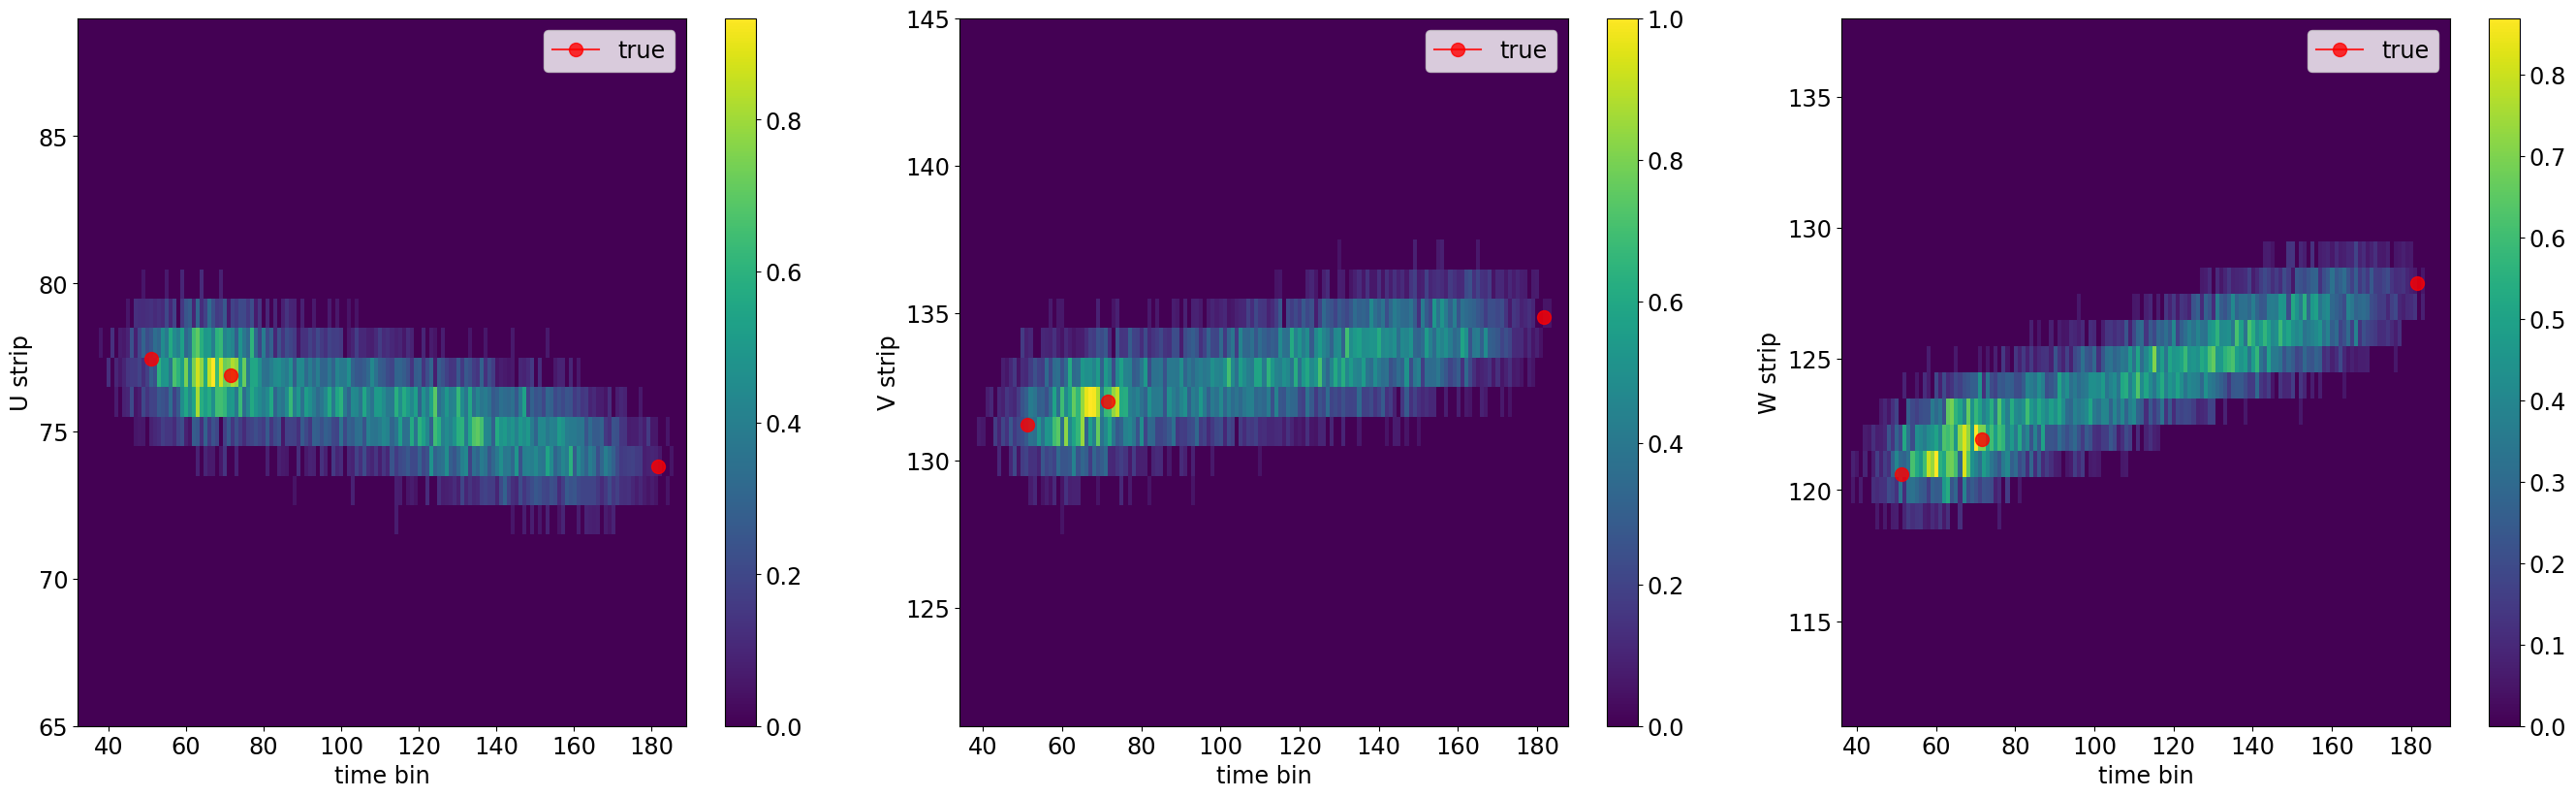

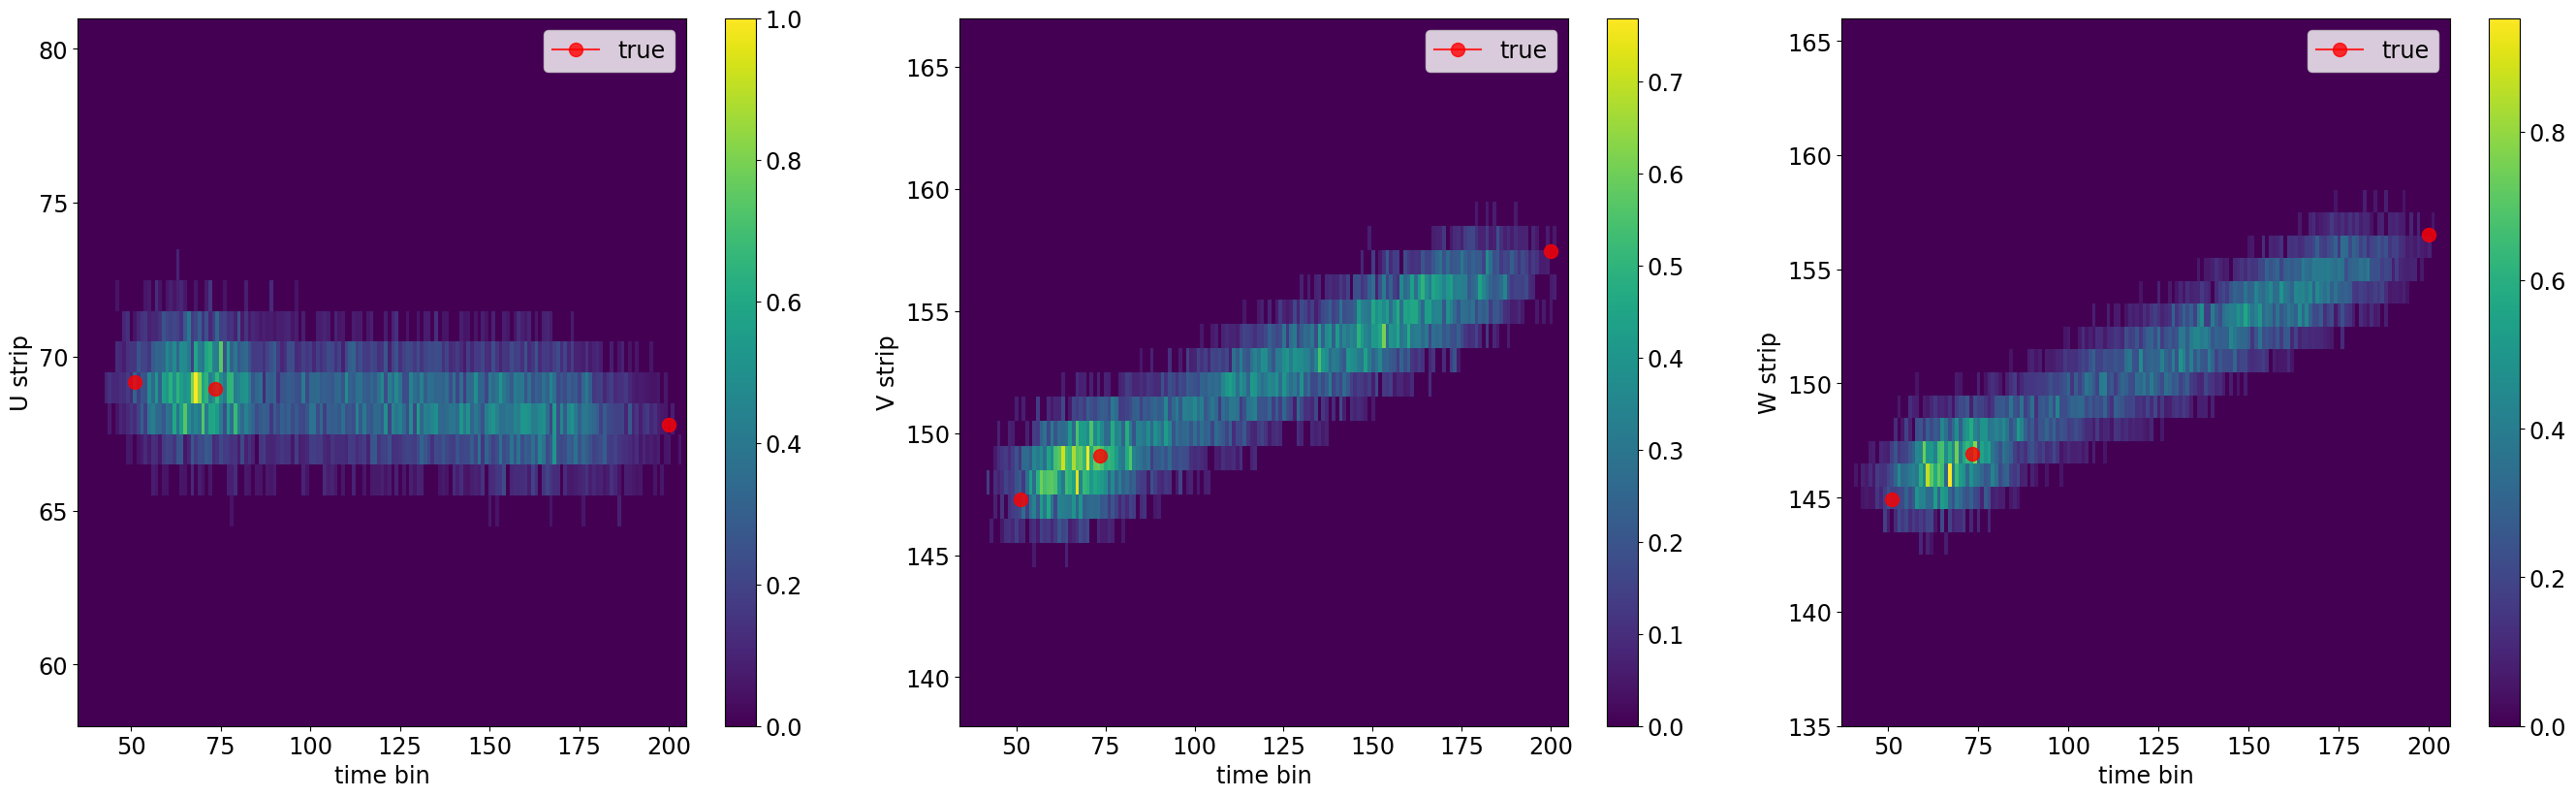

In [5]:
import io_functions as io
importlib.reload(io)

import plotting_functions as plf
importlib.reload(plf)

batchSize = 20

#dataPath = '/scratch_hdd/akalinow/ELITPC/data/PythonAnalysis/E_11_sigma_1.5/'
#train_files = [dataPath+'out_{1,2,3}.root:TPCData']

dataPath = 'drive/MyDrive/ZPS/'
train_files = [dataPath+'out_random_sigma-001.root:TPCData']

datasetGenerator = partial(io.generator, files=train_files, batchSize=batchSize)

train_dataset = tf.data.Dataset.from_generator(
     datasetGenerator,
     output_signature=(
         tf.TensorSpec(shape=(batchSize,) + (io.projections.shape), dtype=tf.float32),
         tf.TensorSpec(shape=(batchSize,9), dtype=tf.float32)))

for aBatch in train_dataset.take(1):
    plf.plotEvent(aBatch, model=None)
    pass

dataPath = 'drive/MyDrive/ZPS/'
test_files = [dataPath+'out_random_sigma2k2mm.root:TPCData']
datasetGenerator = partial(io.generator, files=test_files, batchSize=batchSize)

test_dataset = tf.data.Dataset.from_generator(
     datasetGenerator,
     output_signature=(
         tf.TensorSpec(shape=(batchSize,) + (io.projections.shape), dtype=tf.float32),
         tf.TensorSpec(shape=(batchSize,9), dtype=tf.float32)))

for aBatch in test_dataset.take(1):
    plf.plotEvent(aBatch, model=None)
    pass

## Model definition

In [6]:
model = tf.keras.Sequential([
  tf.keras.layers.Resizing(height=128, width=128),
  #tf.keras.layers.GaussianNoise(stddev=0.1),
  tf.keras.layers.Conv2D(16, 5, padding='same', activation='relu',
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu',
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 5, padding='same', activation='relu',
                         data_format="channels_last"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(9)
])

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=5000,
                decay_rate=0.98,
                staircase=False)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(optimizer = optimizer,
              loss = 'mse',
              metrics=['mse'])

## Model training

5000/5000 [==============================] - 5177s 1s/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0056 - val_mse: 0.0056
Training start. Current Time = 2023_Nov_08_22_09_02
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)      

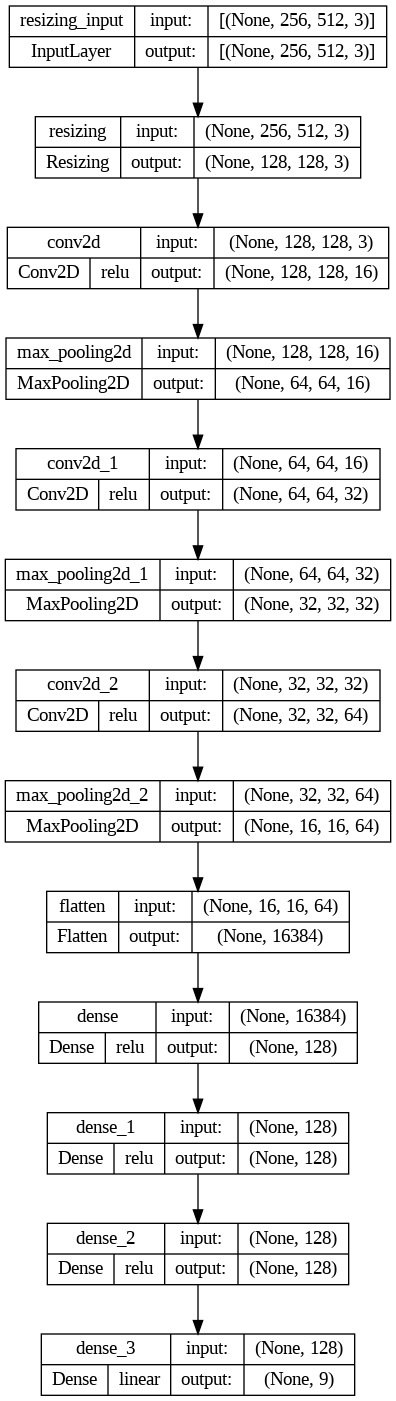

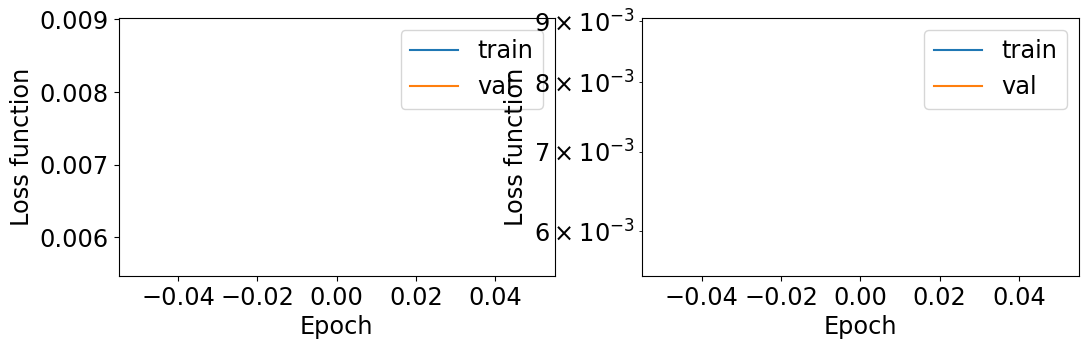

In [7]:
%%time

import plotting_functions as plf
importlib.reload(plf)

log_dir = "drive/MyDrive/ZPS/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=(10, 20))
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)
callbacks =  [tensorboard_callback]

epochs=1 # adjust me

history = model.fit(train_dataset,
                    epochs=epochs,
                    #verbose = 0,
                    workers = 3,
                    use_multiprocessing = True,
                    validation_data = test_dataset.take(10),
                    callbacks=callbacks
                    )
plf.plotTrainHistory(history)

current_time = datetime.now().strftime("%Y_%b_%d_%H_%M_%S")
print("Training start. Current Time =", current_time)

job_dir = "drive/MyDrive/ZPS/training/{epochs:04d}_"+current_time
model.save(job_dir.format(epochs=epochs), save_format='tf')

model.summary()
tf.keras.utils.plot_model(
    model, to_file="drive/MyDrive/ZPS/fig_png/model.png",
    show_shapes=True, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=False,
    dpi=96, layer_range=None,
    show_layer_activations=True, show_trainable=False)

## Model performance on training data.

Fill Pandas DataFrame with true and response values.

Inference. Current Time = 2023_Nov_08_22_10_33
CPU times: user 1min 37s, sys: 21.5 s, total: 1min 58s
Wall time: 1min 52s


,GEN_StartPosX,GEN_StartPosY,GEN_StartPosZ,GEN_StopPosX_Part1,GEN_StopPosY_Part1,GEN_StopPosZ_Part1,GEN_StopPosX_Part2,GEN_StopPosY_Part2,GEN_StopPosZ_Part2,RECO_StartPosX,RECO_StartPosY,RECO_StartPosZ,RECO_StopPosX_Part1,RECO_StopPosY_Part1,RECO_StopPosZ_Part1,RECO_StopPosX_Part2,RECO_StopPosY_Part2,RECO_StopPosZ_Part2
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.617625,-0.225793,-38.535515,-1.883592,-0.549342,-38.995651,0.255984,-0.231627,-38.503357,1.472469,-1.197239,-38.027122,-5.243689,3.881485,-39.675682,1.943269,-2.039982,-37.962914
std,58.390511,9.730610,18.983532,70.209618,35.836037,22.959059,58.479893,10.635128,22.348078,57.836994,10.103676,18.566114,66.495819,32.828457,19.062910,57.674438,10.125237,21.846369
min,-99.990166,-19.709864,-52.940796,-257.504517,-158.999878,-142.974167,-107.613670,-27.132357,-52.946163,-103.364716,-28.004515,-56.258114,-186.332489,-105.850006,-82.023956,-103.087784,-29.568110,-57.990986
25%,-49.187802,-8.126993,-50.165648,-52.245084,-20.479304,-52.946163,-48.599941,-8.263395,-52.946163,-46.339119,-9.021275,-49.368865,-53.658685,-14.802228,-51.668079,-46.138247,-9.788708,-52.075294
50%,0.416744,-0.022385,-47.124235,-1.107173,-0.203776,-52.946163,-0.737147,-0.126421,-52.620352,2.356385,-1.550987,-45.992348,-5.119701,3.144303,-47.960848,2.432824,-2.021304,-48.318310
75%,52.779685,7.647571,-34.067449,52.218331,20.187787,-30.626680,52.399117,7.679490,-30.629385,54.058054,6.555582,-33.776627,49.445513,21.375263,-32.331905,53.811578,5.736475,-31.272974
max,99.916092,19.577881,56.373661,196.732803,151.791626,84.042320,107.362175,30.067179,67.289383,104.547211,26.323689,52.607899,164.266037,105.610588,52.088482,107.991493,27.535805,62.834854


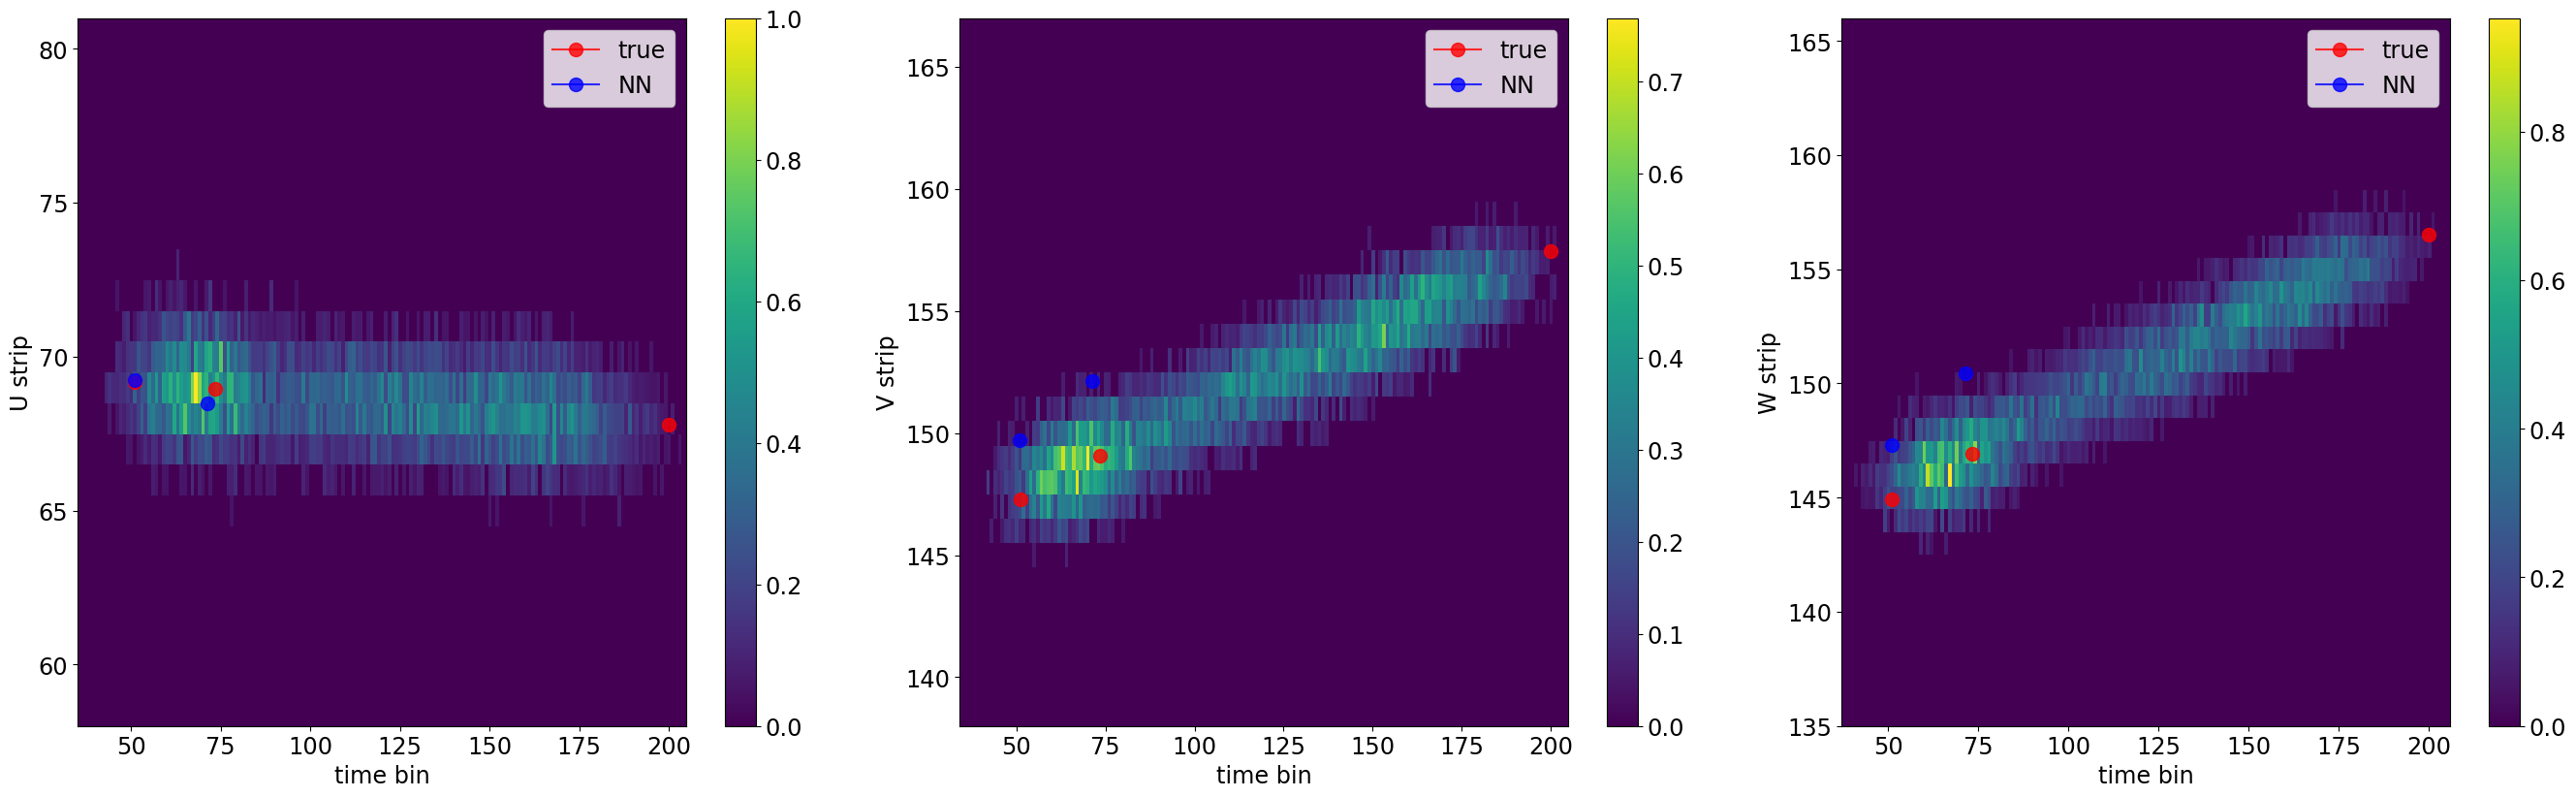

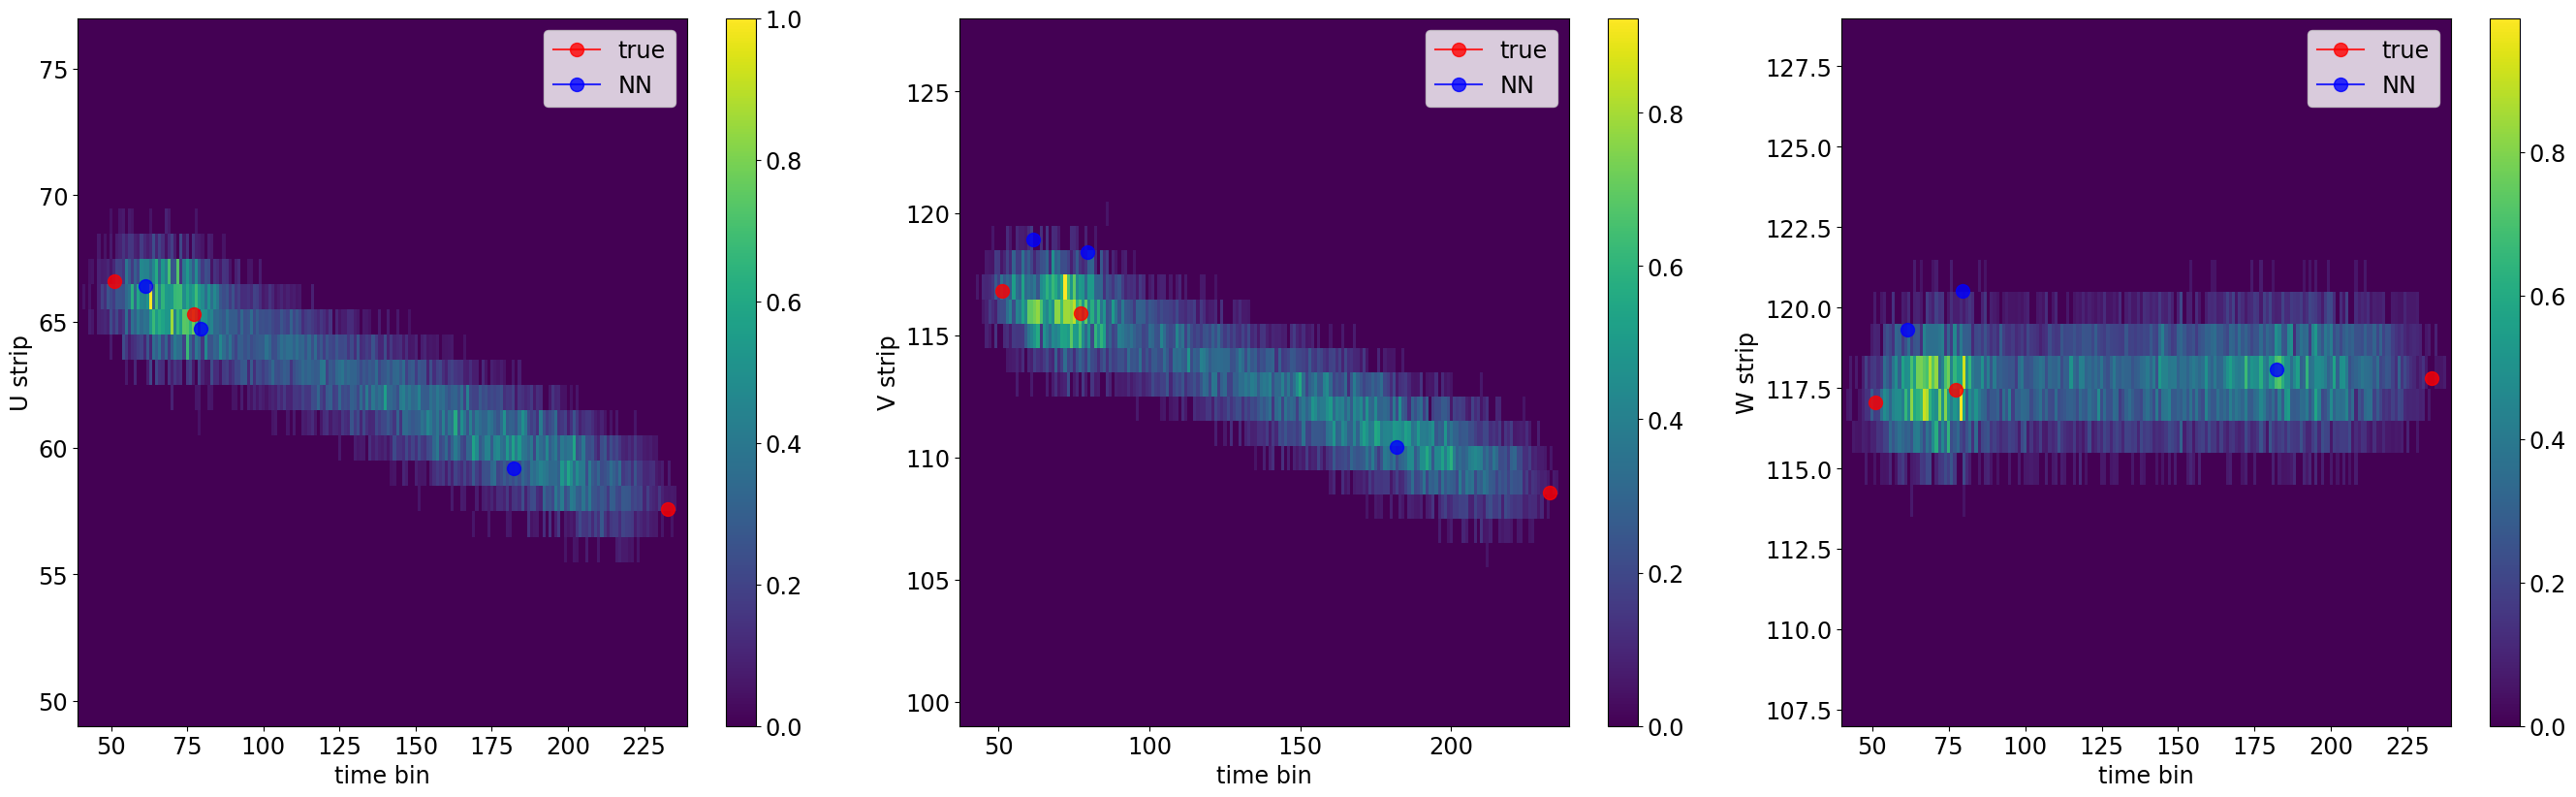

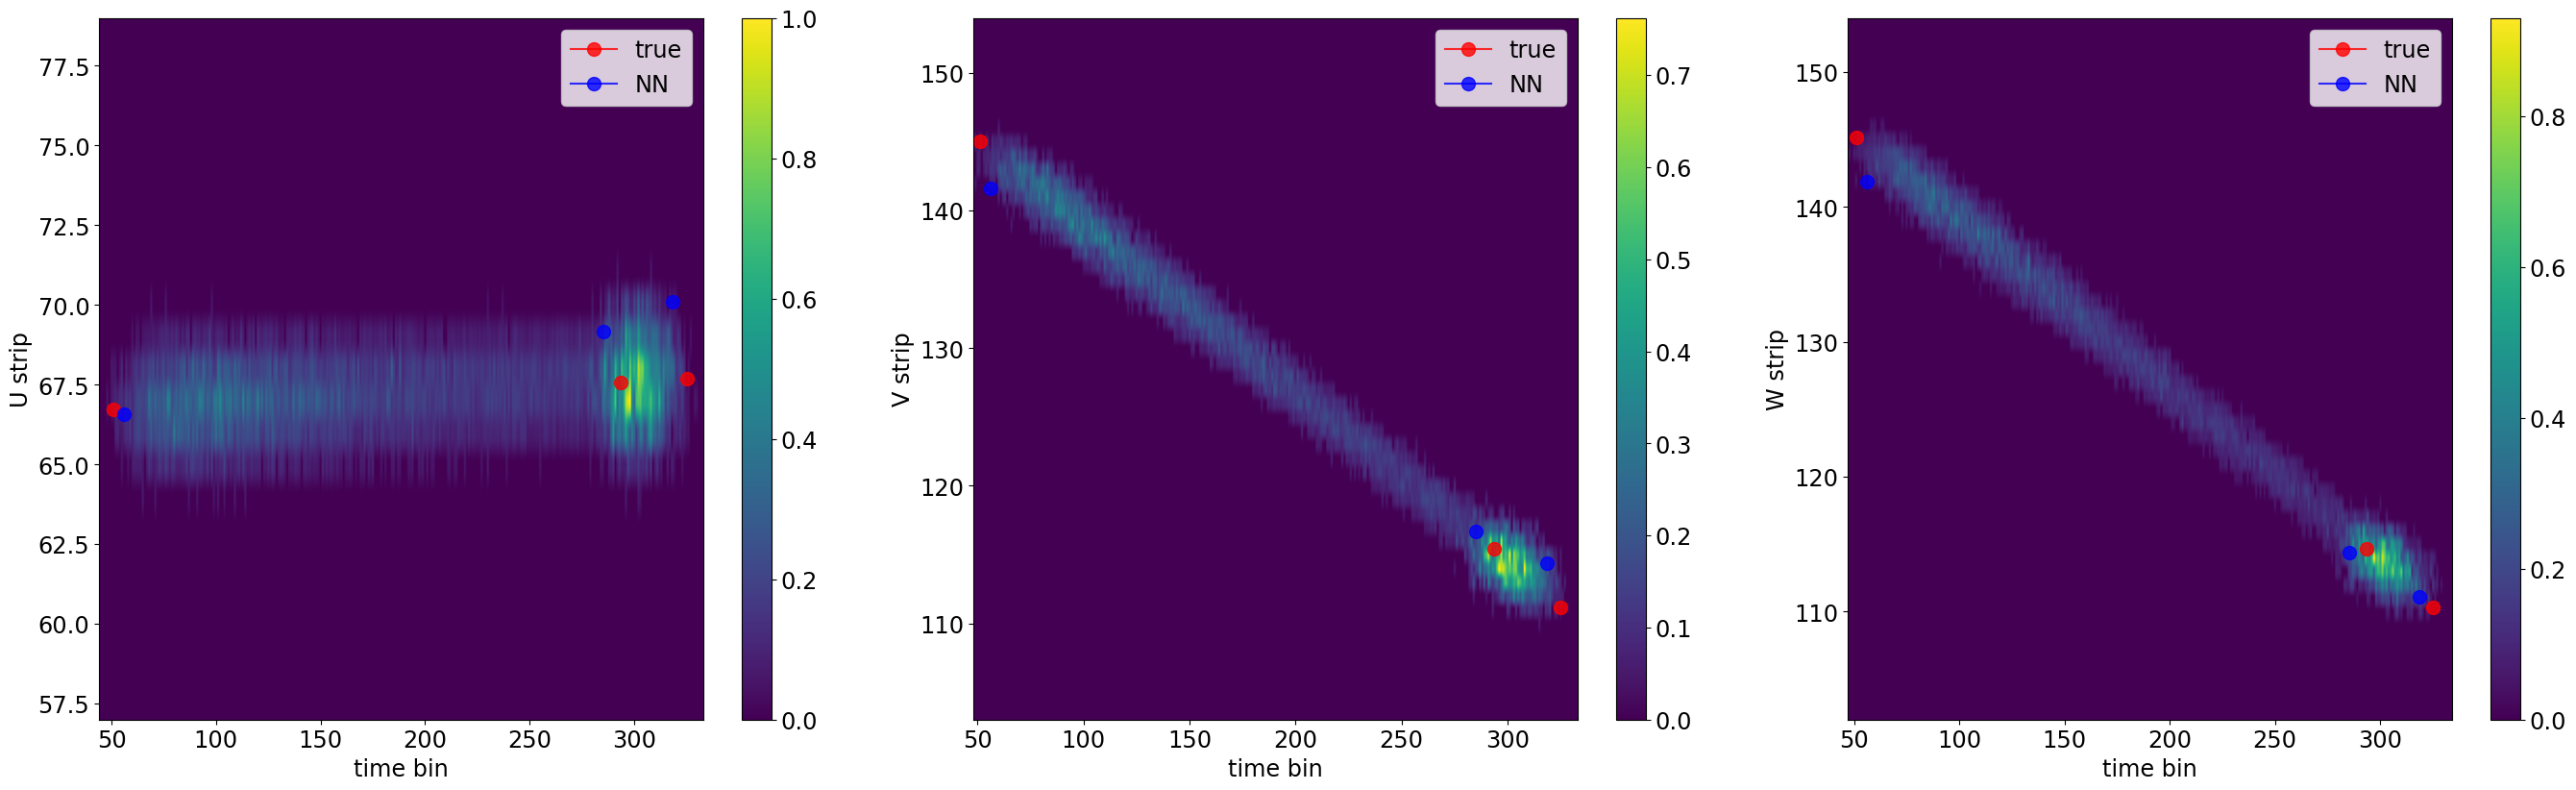

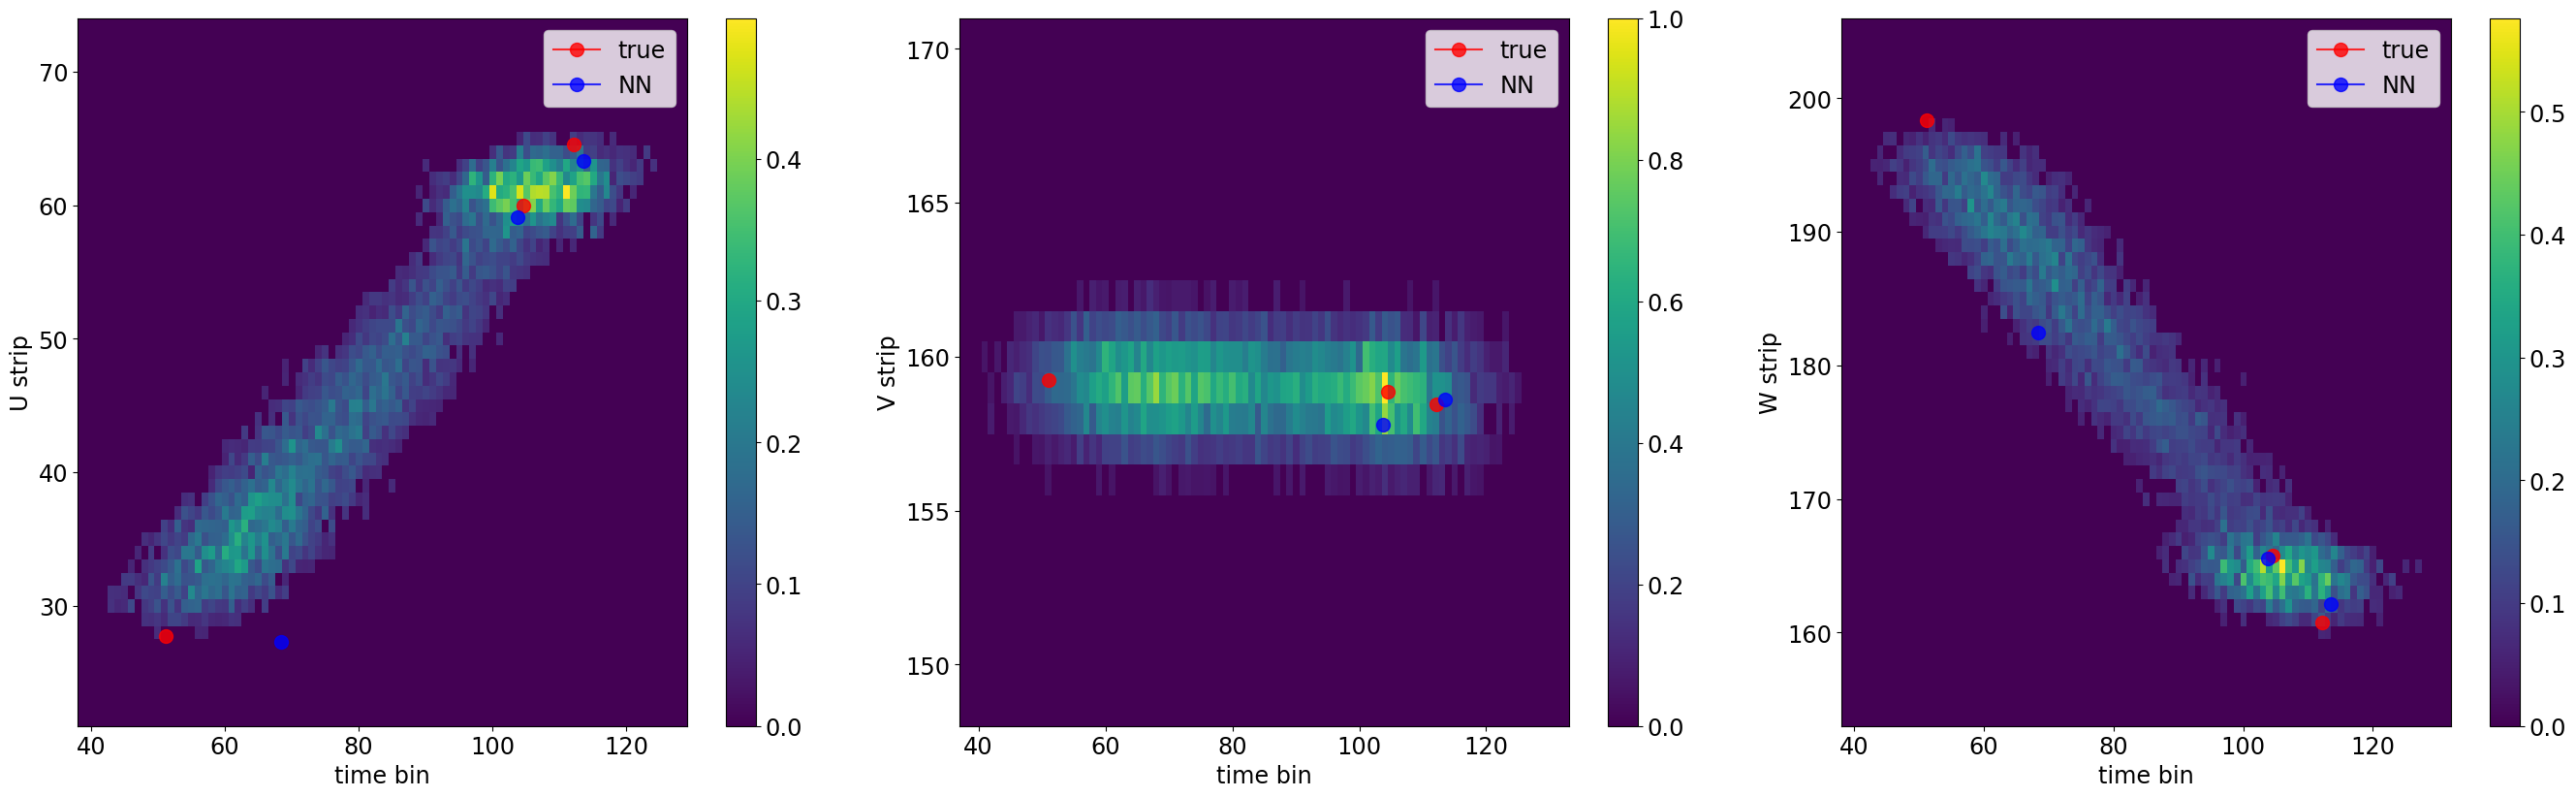

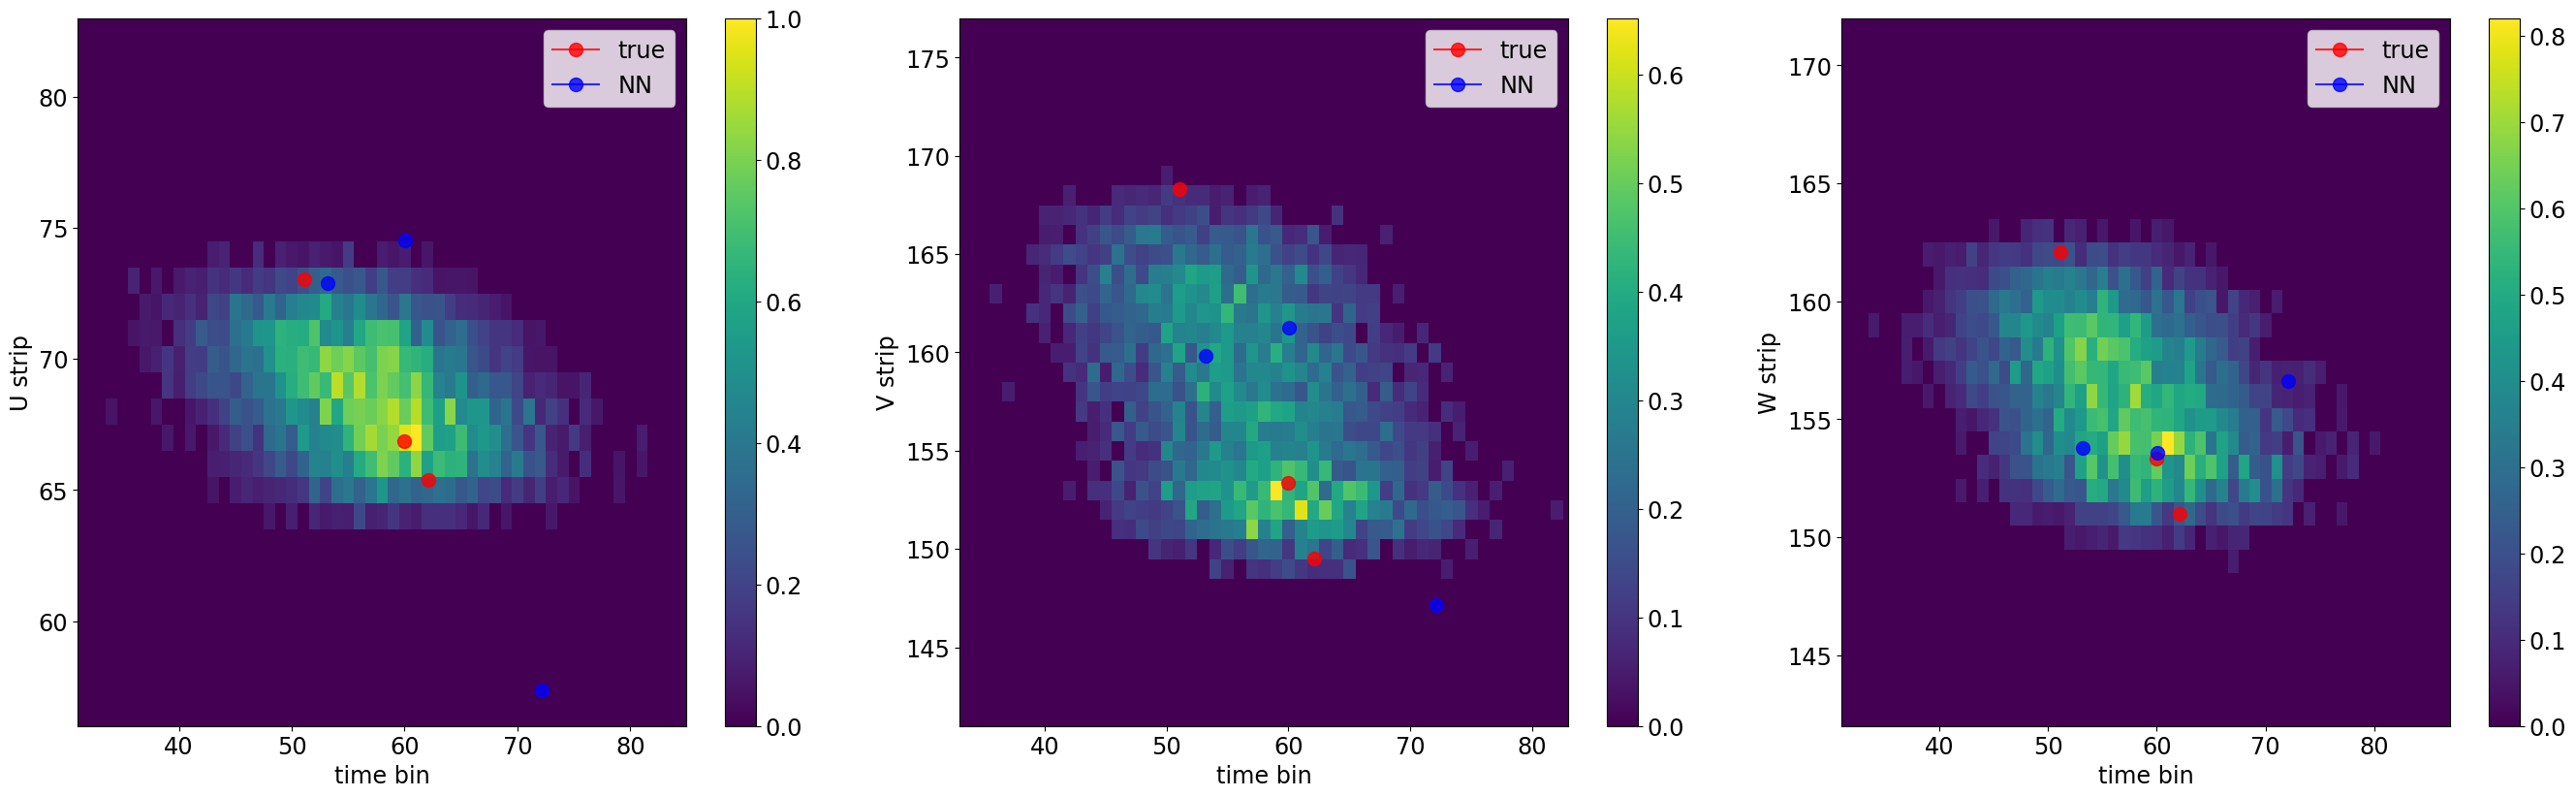

In [8]:
%%time
import utility_functions as utils
importlib.reload(utils)

current_time = datetime.now().strftime("%Y_%b_%d_%H_%M_%S")
print("Inference. Current Time =", current_time)

# loading existing model
#model_path = "drive/MyDrive/ZPS/training/0001_2023_Nov_08_22_09_02/" # path to existing model
#model = tf.keras.models.load_model(model_path)

df = utils.df

for aBatch in test_dataset:
    df = utils.fillPandasDataset(aBatch, df, model)

for aBatch in test_dataset.take(5):
    plf.plotEvent(aBatch, model=model)

df.describe()

### Resolution plots

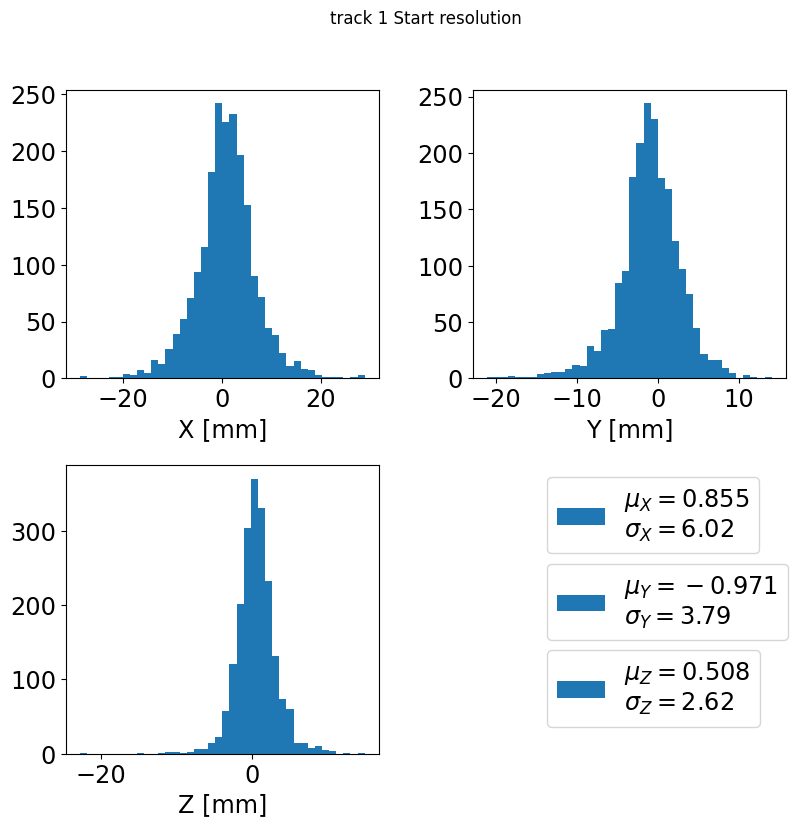

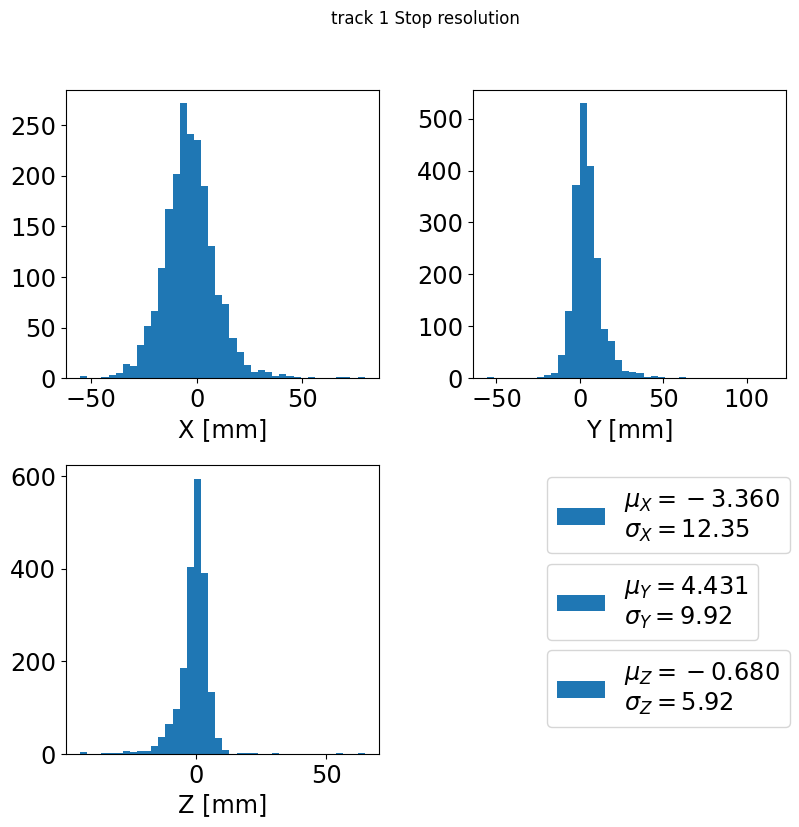

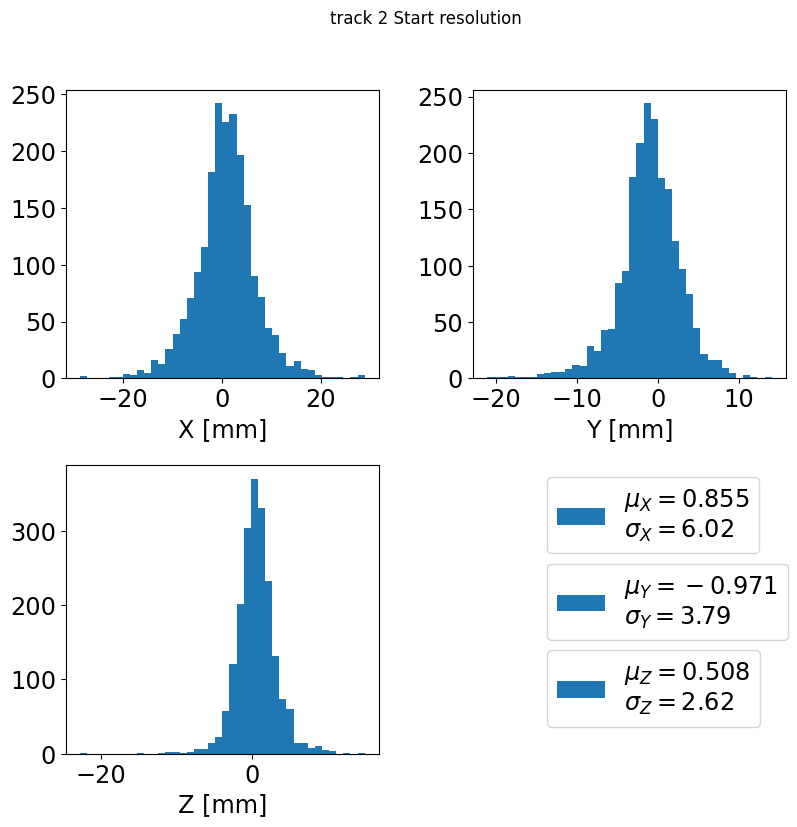

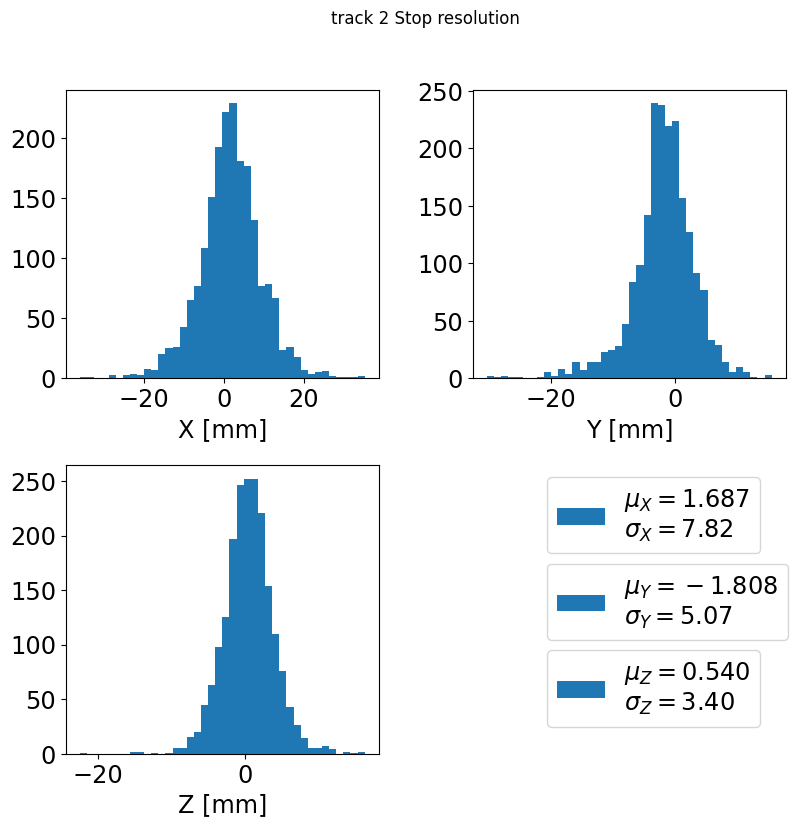

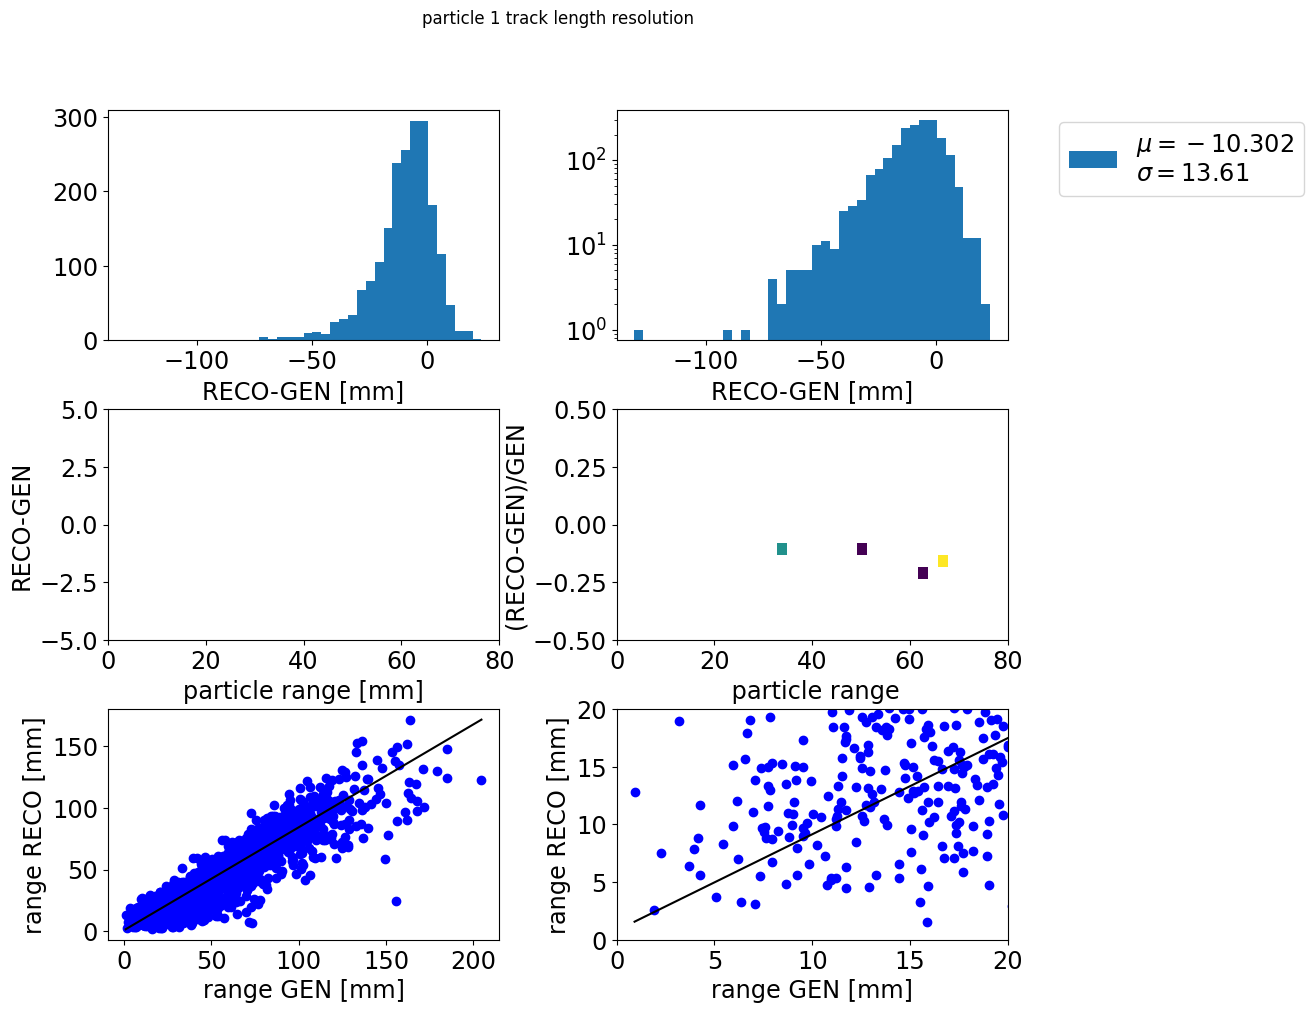

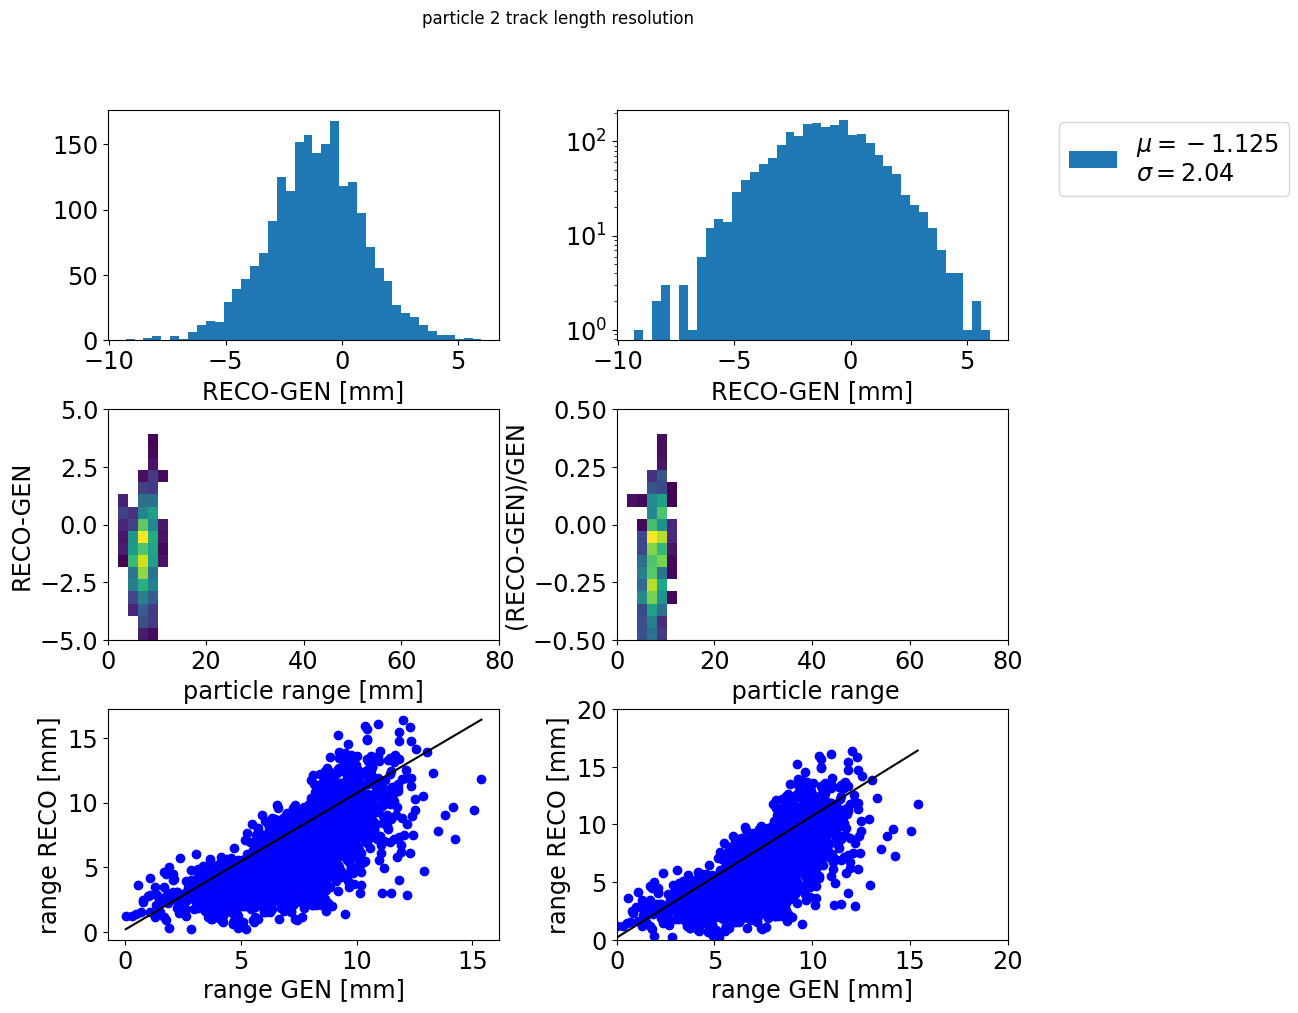

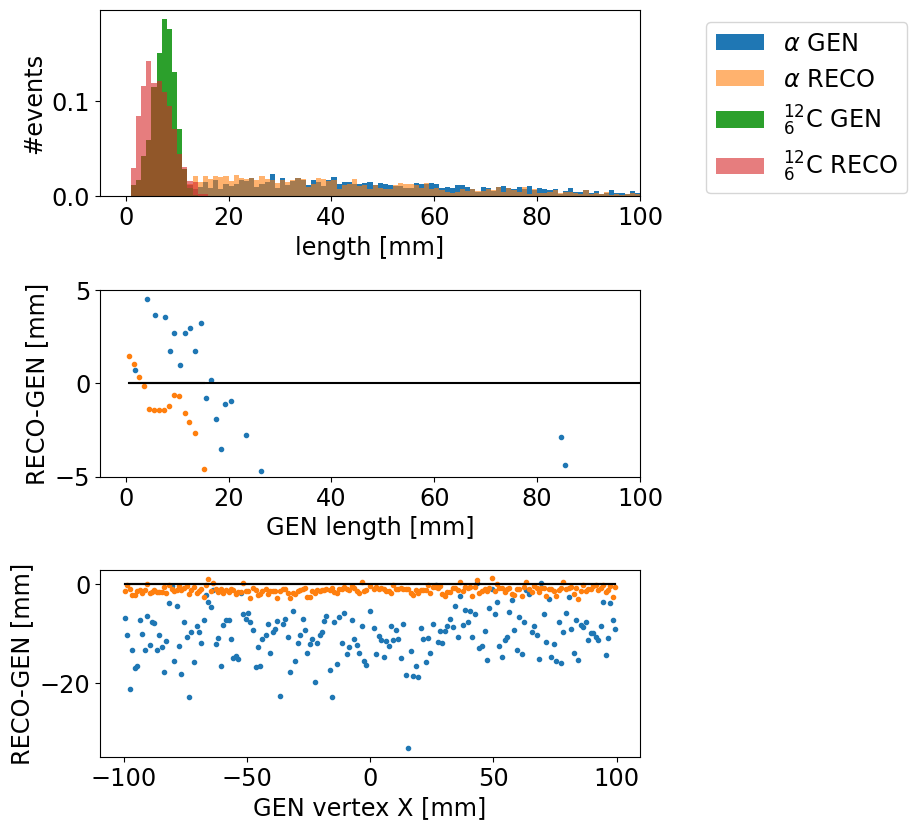

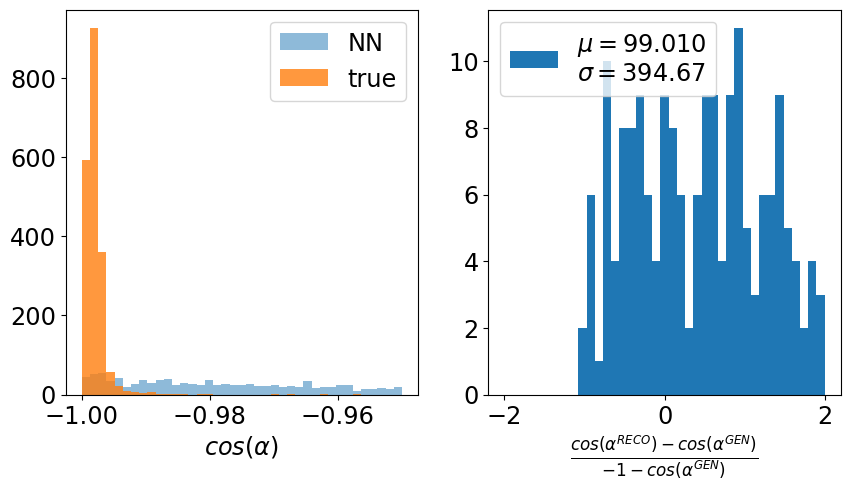

In [9]:
import plotting_functions as plf
importlib.reload(plf)

#plf.controlPlots(df)
plf.plotEndPointRes(df=df, edge="Start", partIdx=1)
plf.plotEndPointRes(df=df, edge="Stop", partIdx=1)

plf.plotEndPointRes(df=df, edge="Start", partIdx=2)
plf.plotEndPointRes(df=df, edge="Stop", partIdx=2)

plf.plotLengthPull(df, partIdx=1)
plf.plotLengthPull(df, partIdx=2)
plf.plotLengthPullEvolution(df)
plf.plotOpeningAngleCos(df)

       GEN_StartPosX  GEN_StartPosY  GEN_StartPosZ  GEN_StopPosX_Part1  \
count     466.000000     466.000000     466.000000          466.000000   
mean        5.861477      -1.114546     -38.654522           -2.241330   
std        59.193130       8.929380      17.955402           65.926178   
min       -99.063461     -19.595749     -52.940796         -156.489212   
25%       -47.203822      -8.071081     -49.623609          -56.687680   
50%         8.763917      -0.869723     -46.685881           -0.795765   
75%        61.296504       5.722162     -35.665414           54.744051   
max        98.977867      18.741270      38.387367          131.300079   

       GEN_StopPosY_Part1  GEN_StopPosZ_Part1  GEN_StopPosX_Part2  \
count          466.000000          466.000000          466.000000   
mean            -0.093511          -36.229885            6.469497   
std             28.308805           23.560116           58.897427   
min           -133.359238          -52.946163          -9

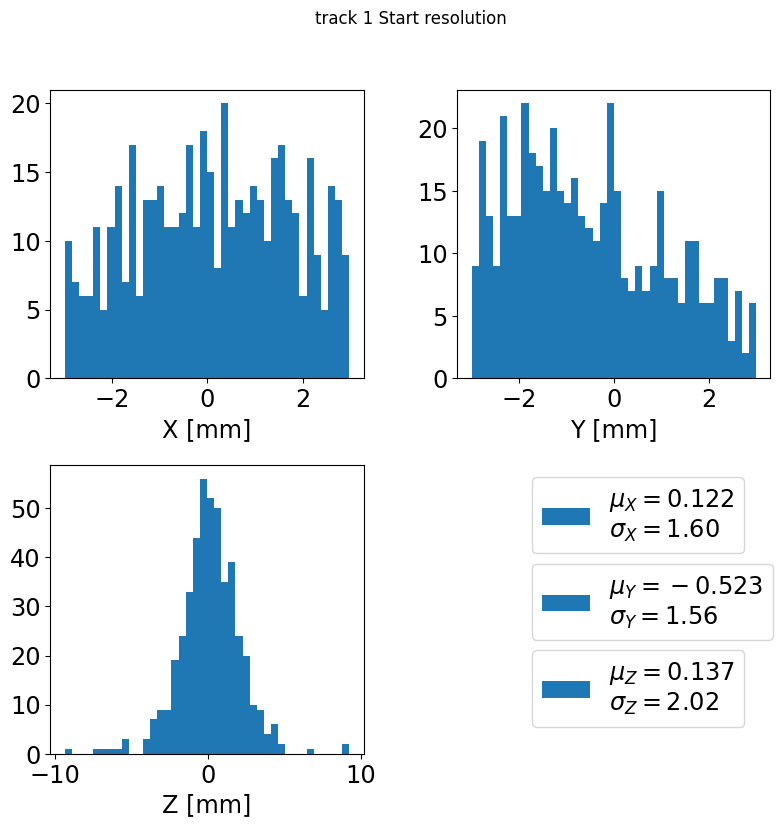

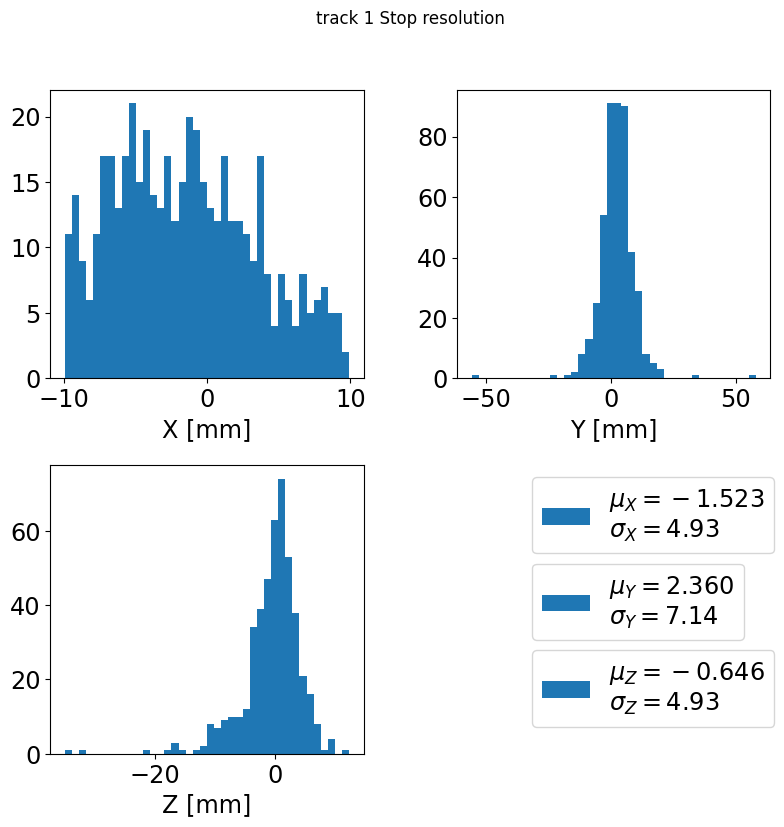

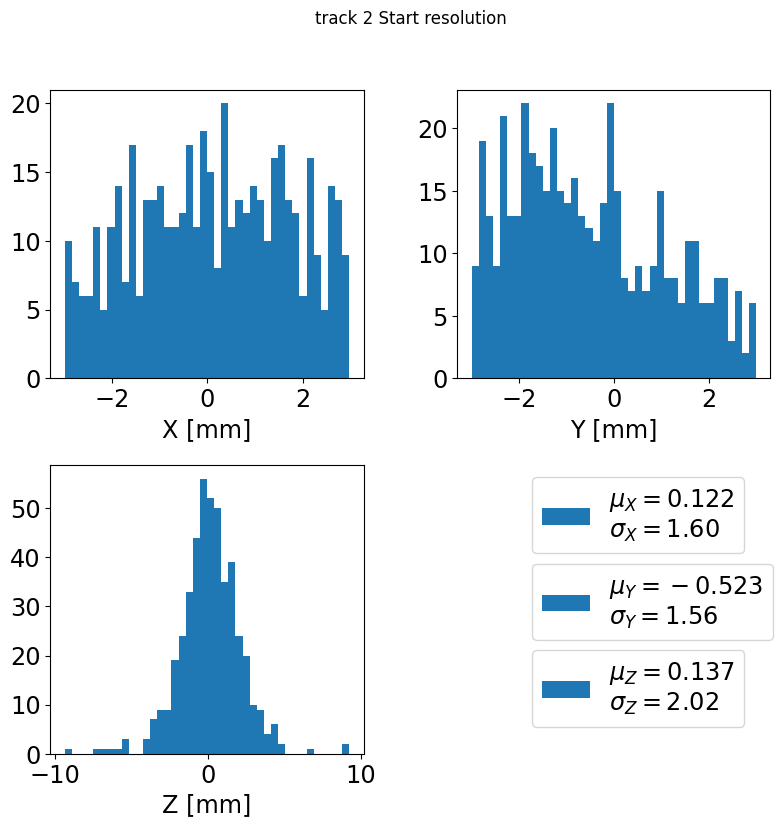

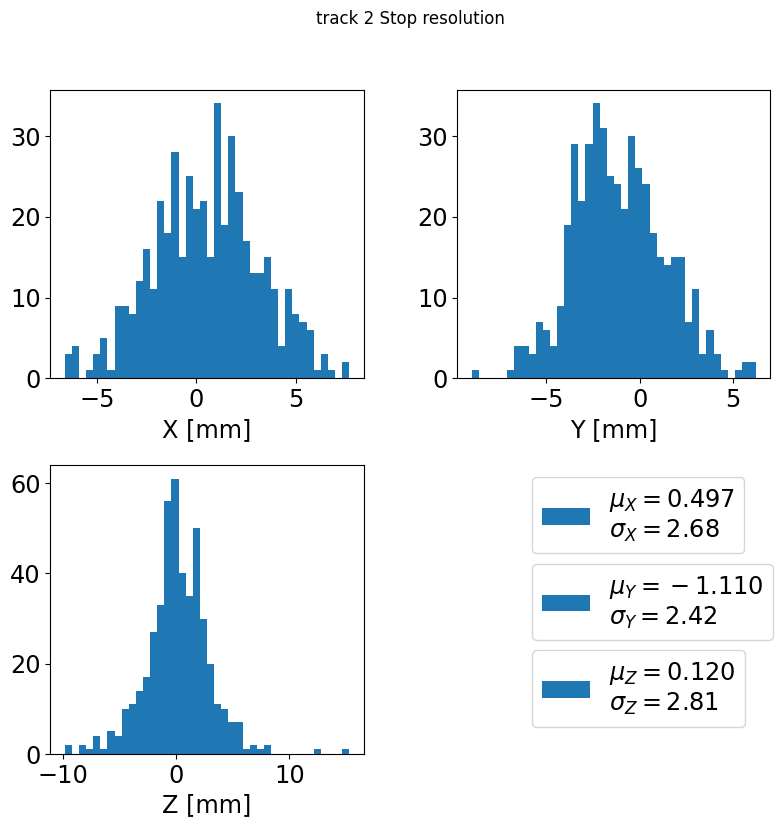

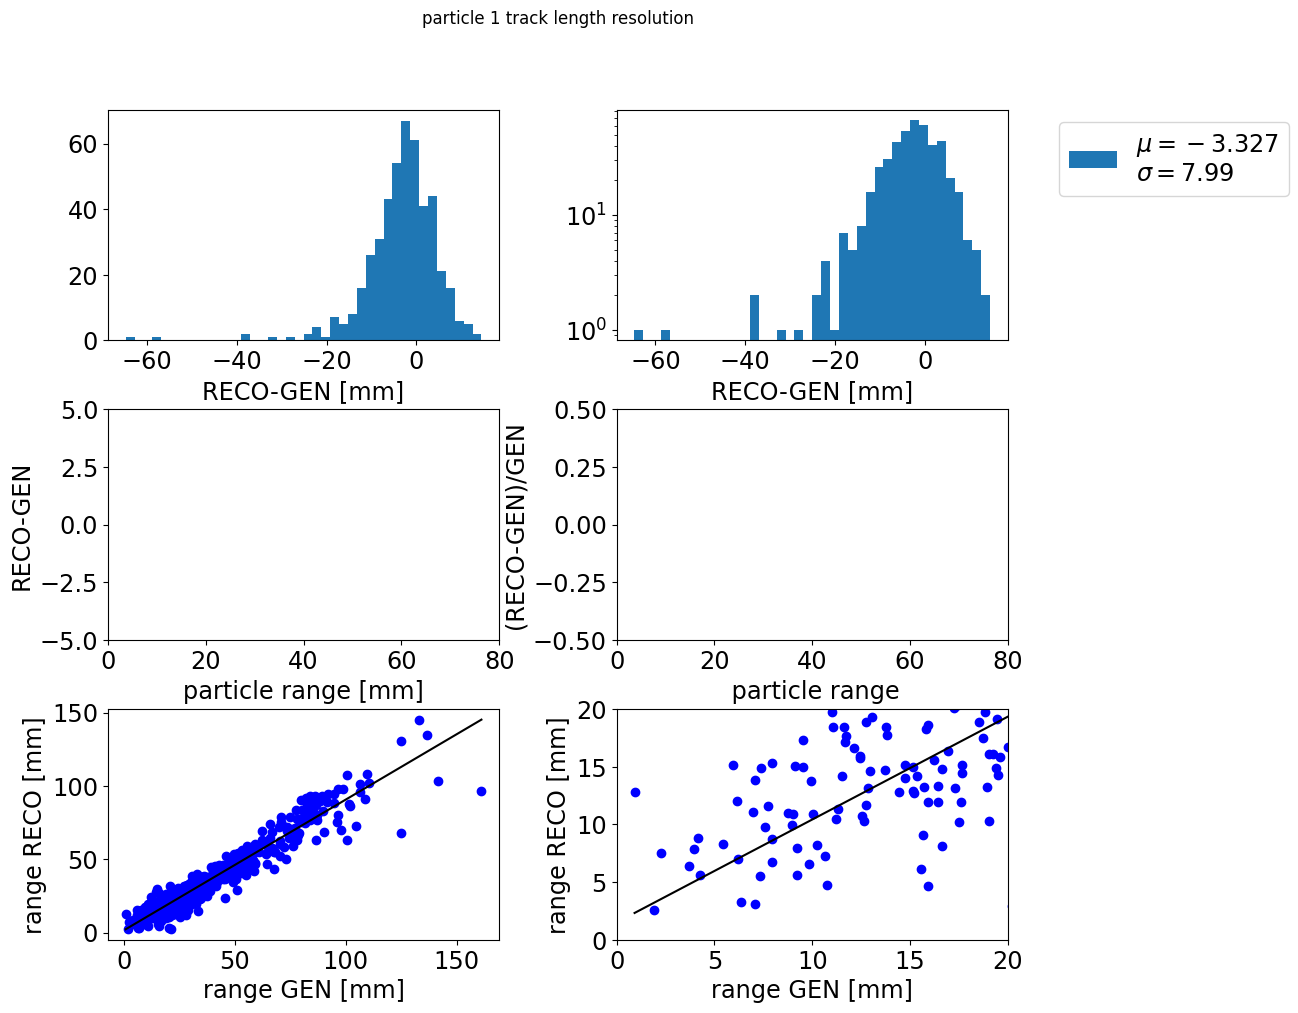

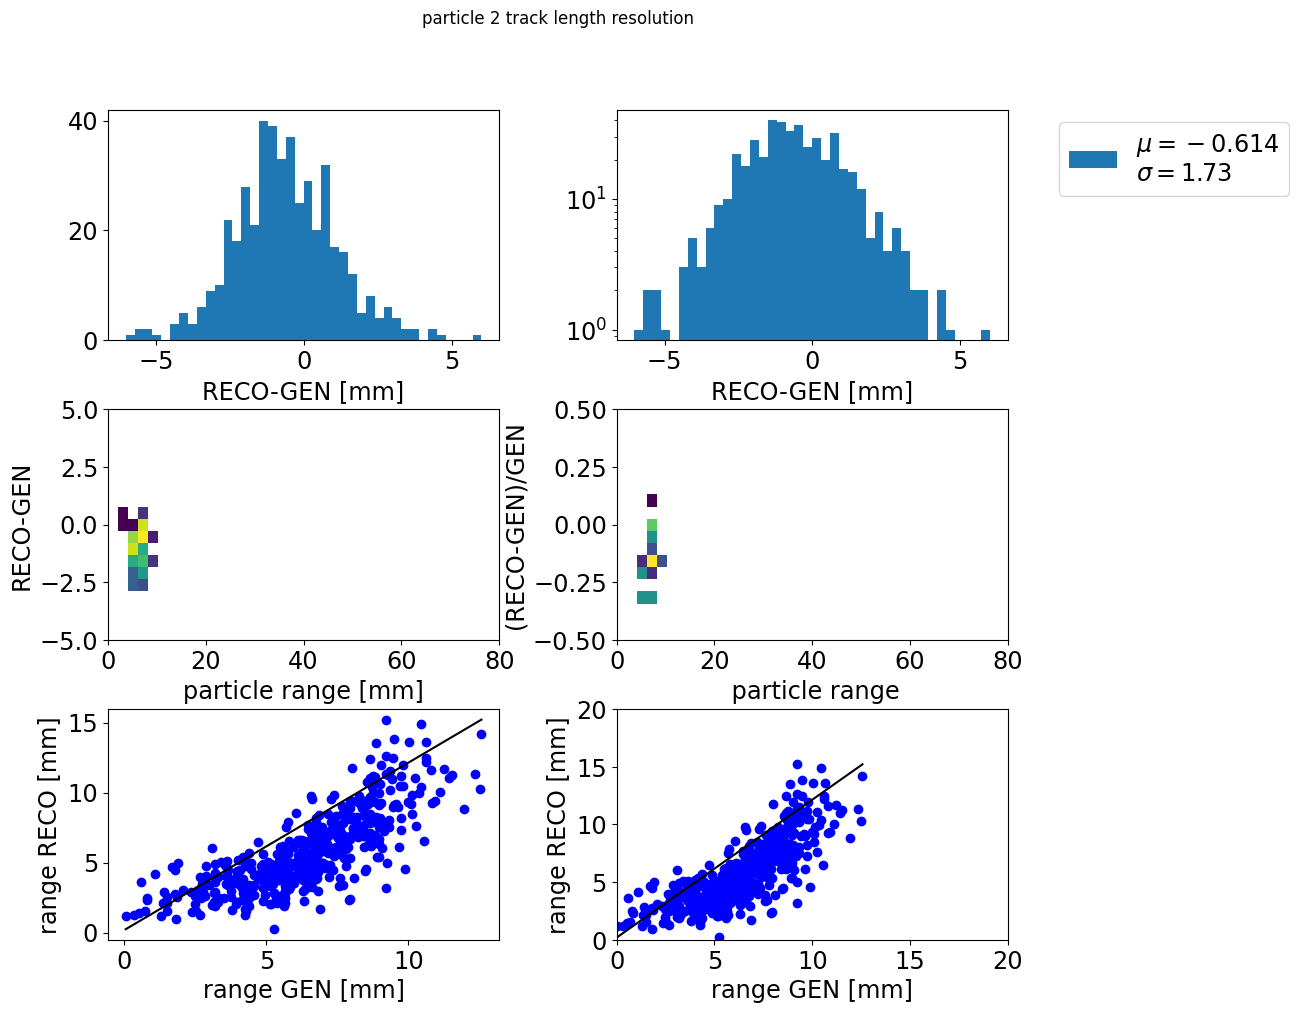

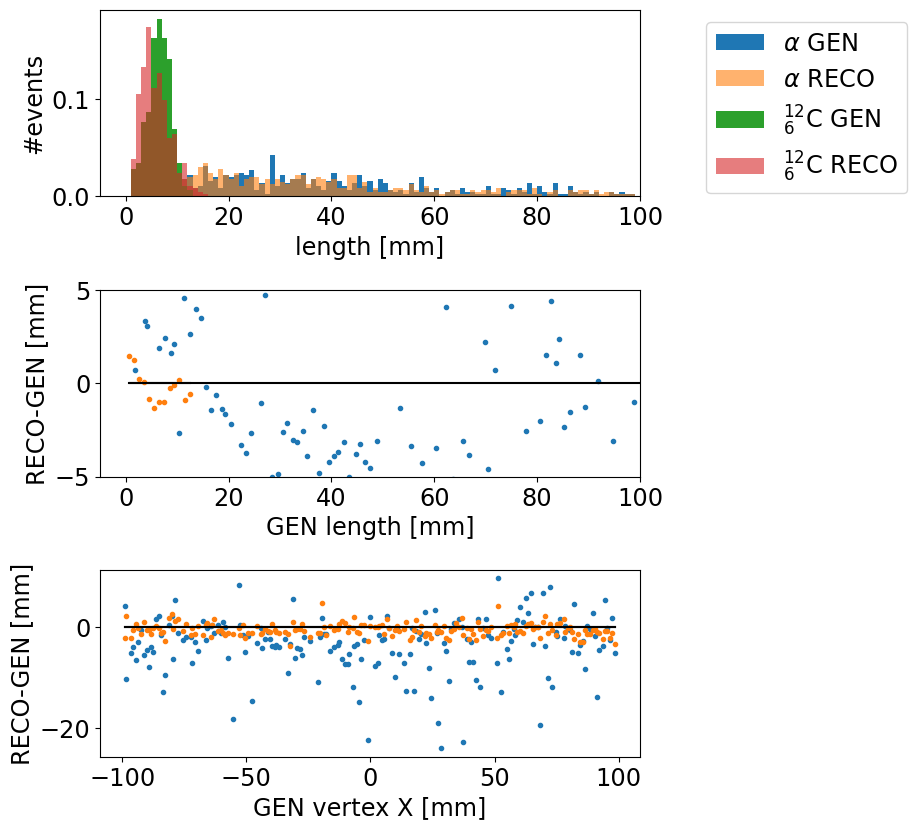

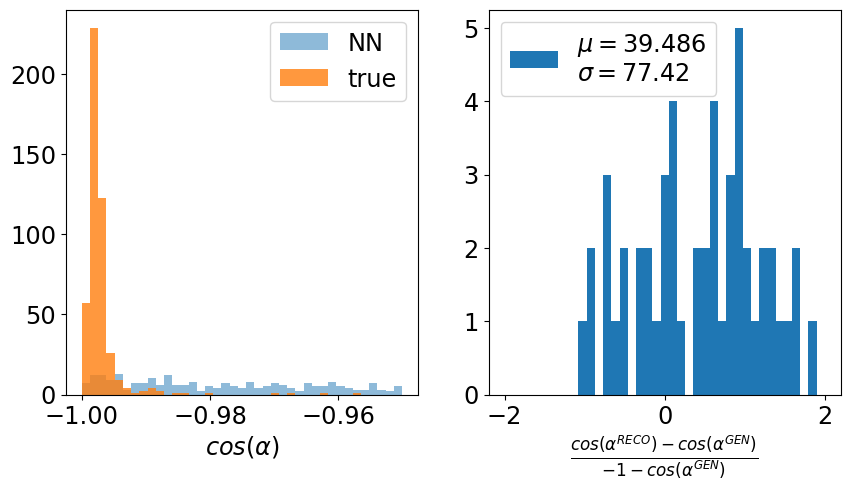

In [10]:
mask = np.abs(df["GEN_StartPosX"] - df["RECO_StartPosX"])<3
df_filtered = df[mask]

mask = np.abs(df_filtered["GEN_StartPosY"] - df_filtered["RECO_StartPosY"])<3
df_filtered = df_filtered[mask]

mask = np.abs(df_filtered["GEN_StopPosX_Part1"] - df_filtered["RECO_StopPosX_Part1"])<10
df_filtered = df_filtered[mask]

print(df_filtered.describe())

plf.plotEndPointRes(df=df_filtered, edge="Start", partIdx=1)
plf.plotEndPointRes(df=df_filtered, edge="Stop", partIdx=1)

plf.plotEndPointRes(df=df_filtered, edge="Start", partIdx=2)
plf.plotEndPointRes(df=df_filtered, edge="Stop", partIdx=2)

plf.plotLengthPull(df_filtered, partIdx=1)
plf.plotLengthPull(df_filtered, partIdx=2)
plf.plotLengthPullEvolution(df_filtered)
plf.plotOpeningAngleCos(df_filtered)